# Destroyed Grammar of Prompts

In [1]:
# Step1: import the libraries
import torch
import clip
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Step 2: Load CLIP Model and CIFAR-10 Data
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

cifar10 = CIFAR10(root="./data", download=True, train=False, transform=Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
]))
data_loader = DataLoader(cifar10, batch_size=64, shuffle=False)

Files already downloaded and verified


In [3]:
# Step 3: Define Class Prompts
class_names = cifar10.classes
# "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
prompts = ["photos {} of a many".format(class_name) for class_name in class_names]
text_inputs = clip.tokenize(prompts).to(device)

In [4]:
# Step 4: Evaluate Model on Test Data
model.eval()
correct = 0
total = 0
# Initialize counters for each class
correct_per_class = {class_name: 0 for class_name in class_names}
total_per_class = {class_name: 0 for class_name in class_names}

with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images = images.to(device)
        labels = labels.cpu()  # Move labels to CPU for easier processing

        # Calculate image and text features
        image_features = model.encode_image(images)
        text_features = model.encode_text(text_inputs)

        # Normalize features and calculate similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Convert similarity to float32 and get top predictions
        similarity = similarity.to(torch.float32)
        _, top_labels = similarity.cpu().topk(1, dim=-1)

        # Update counters for each class
        for label, top_label in zip(labels, top_labels[:, 0]):
            class_name = class_names[label]
            total_per_class[class_name] += 1
            if label == top_label:
                correct_per_class[class_name] += 1

100%|██████████| 157/157 [00:20<00:00,  7.80it/s]


In [5]:
# Calculate and print accuracies for each class
class_accuracies = {}
for class_name in class_names:
    accuracy = 100 * correct_per_class[class_name] / total_per_class[class_name]
    class_accuracies[class_name] = accuracy
    print(f"Accuracy for {class_name}: {accuracy:.2f}%")

Accuracy for airplane: 61.30%
Accuracy for automobile: 99.00%
Accuracy for bird: 92.40%
Accuracy for cat: 78.50%
Accuracy for deer: 85.80%
Accuracy for dog: 86.60%
Accuracy for frog: 71.10%
Accuracy for horse: 93.60%
Accuracy for ship: 91.10%
Accuracy for truck: 66.70%


In [6]:
accuracies = [0]*10
correct = 0
i = 0
for class_name in class_names:
    accuracies[i] = class_accuracies[class_name]
    correct += class_accuracies[class_name]
    i += 1

Accuracy: 82.61%


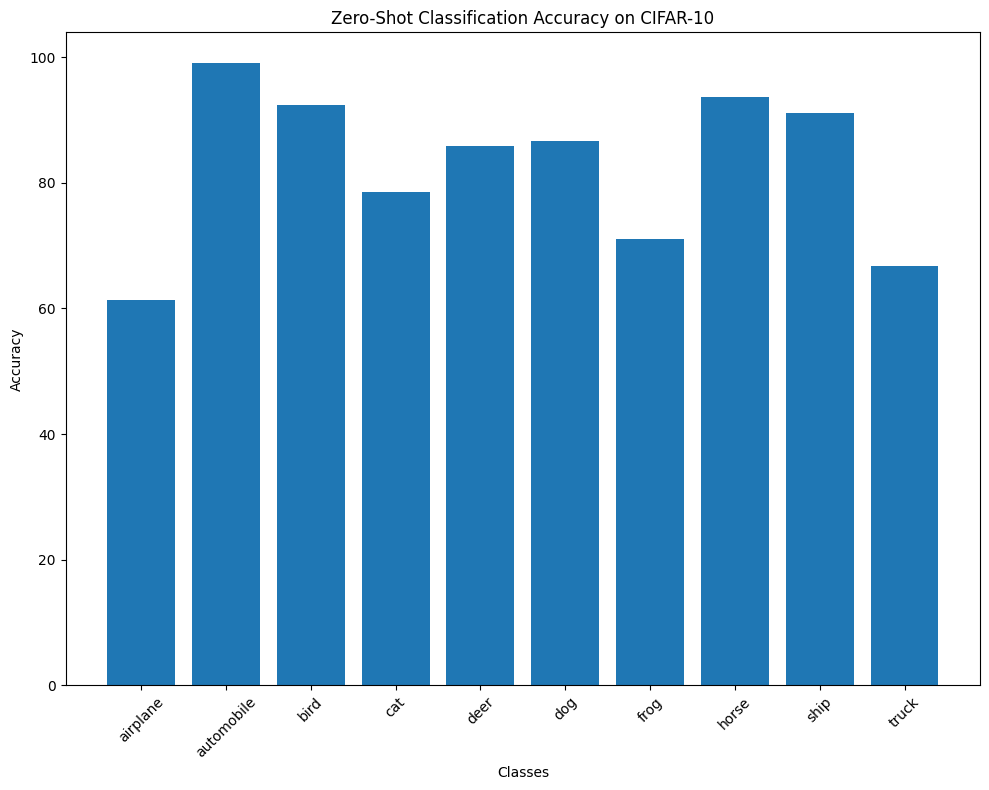

In [7]:
# Step 5: Plot or Tabulate Results
accuracy = correct / 10
print(f"Accuracy: {accuracy:.2f}%")

# Plot Results
plt.figure(figsize=(10,8))  # Increase the plot size if needed
plt.bar(class_names, accuracies)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Zero-Shot Classification Accuracy on CIFAR-10')
plt.xticks(rotation=45)  # Rotate labels to 45 degrees
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()